## Import packages & Load Data

In [216]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)

from sklearn import metrics

In [217]:
path = "./Survey/AnomalyDetectionSurvey/KPI异常检测决赛数据集/phase2_train.csv"
data = pd.read_csv(path)
data.describe

<bound method NDFrame.describe of           timestamp      value  label                                KPI ID
0        1476460800   0.012604      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
1        1476460860   0.017786      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
2        1476460920   0.012014      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
3        1476460980   0.017062      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
4        1476461040   0.023632      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
...             ...        ...    ...                                   ...
3004061  1500012600  38.130000      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
3004062  1500012660  37.480000      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
3004063  1500012720  37.220000      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
3004064  1500012780  36.390000      0  42d6616d-c9c5-370a-a8ba-17ead74f3114
3004065  1500012840  37.390000      0  42d6616d-c9c5-370a-a8ba-17ead74f3114

[3004066 rows x 4 columns]>

In [218]:
data

,timestamp,value,label,KPI ID
0,1476460800,0.012604,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
1,1476460860,0.017786,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
2,1476460920,0.012014,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
3,1476460980,0.017062,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
4,1476461040,0.023632,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
...,...,...,...,...
3004061,1500012600,38.130000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
3004062,1500012660,37.480000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
3004063,1500012720,37.220000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
3004064,1500012780,36.390000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114


## EDA

### Get non-duplicated KPI IDs

In [219]:
data.columns

Index(['timestamp', 'value', 'label', 'KPI ID'], dtype='object')

In [220]:
unq = data[['KPI ID']].drop_duplicates()
unq.shape #(29, 1)
unq = unq['KPI ID'].tolist()
len(unq)

29

### Explore some one by one

In [221]:
number = 0
KPI_name = unq[number]
selected = data[data['KPI ID'] == KPI_name]
selected = selected.drop('KPI ID', axis=1)
anomaly  = selected.query('label == 1')
#selected.shape[0] # (107717, 4)
#anomaly#.index # 7363
print("Anomaly percentage is", round(100*anomaly.shape[0]/selected.shape[0], 4), "%")

Anomaly percentage is 6.8355 %


Text(0.5, 1.0, 'The 1 th KPI name')

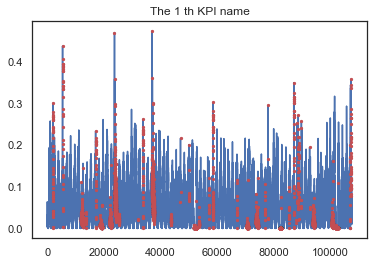

In [222]:
plt.plot(selected.value, zorder=1)
plt.scatter(anomaly.index, anomaly.value, color="r", s=5, zorder=2)
plt.title("The " + str(number + 1) + " th KPI name")

Text(0.5, 1.0, 'For all values')

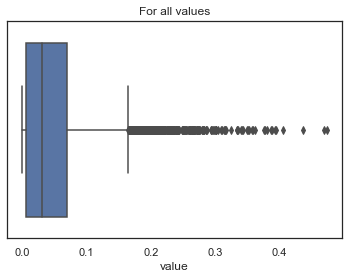

In [223]:
#此 KPI ID 所有 value 的 boxplot
sns.set_theme(style="white")
sns.boxplot(x=selected.value).set_title("For all values")
# Lots of extreme values

Text(0.5, 1.0, 'Anomalies only')

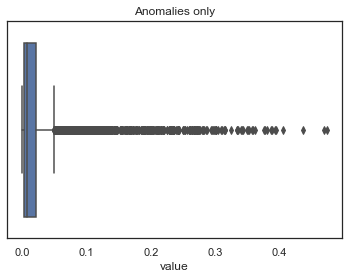

In [224]:
#此 KPI ID anomaly value 的 boxplot
sns.boxplot(x=anomaly.value).set_title("Anomalies only")
# Anomalies Not only appear as extreme values

In [225]:
def show_all(num):
    number = num
    KPI_name = unq[number]
    selected = data[data['KPI ID'] == KPI_name]
    anomaly  = selected.query('label == 1')
    print("Anomaly percentage for "+str(number+1)+"th", "is", round(100*anomaly.shape[0]/selected.shape[0], 4), "%")
    # time series with anomalies
    fig, ax = plt.subplots()
    ax.plot(selected.value, zorder=1)
    ax.scatter(anomaly.index, anomaly.value, color="r", s=5, zorder=2)
    plt.title("The " + str(number + 1) + " th KPI name")
    plt.show()
    # boxplot
    fig, axes = plt.subplots(1,2,figsize=(15, 5))
    fig.suptitle("Boxplots")
    sns.boxplot(ax=axes[0], x=selected.value).set_title("For all values")
    sns.boxplot(ax=axes[1], x=anomaly.value).set_title("Anomalies only")

In [226]:
# for i in range(29):
#     show_all(i)

### 分类处理，稳定型 & 波动型
### https://mp.weixin.qq.com/s/Bt80RXumkLproR5BFIo2EQ#at

### Split into train & eval

In [227]:
ratio_1 = 0.5
ratio_2 = 0.8
num_split_1 = int(selected.shape[0]*ratio_1)
num_split_2 = int(selected.shape[0]*ratio_2)
train = selected[:num_split_1]
evalt = selected[num_split_1:num_split_2]
testt = selected[num_split_2:]

In [228]:
from statsmodels.graphics.tsaplots import plot_acf
#plot_acf(train.value, lags=50)
train

,timestamp,value,label
0,1476460800,0.012604,0
1,1476460860,0.017786,0
2,1476460920,0.012014,0
3,1476460980,0.017062,0
4,1476461040,0.023632,0
...,...,...,...
53853,1479698340,0.037085,0
53854,1479698400,0.071639,0
53855,1479698460,0.063571,0
53856,1479698520,0.045712,0


## 特征工程

####  按时间序列通过滑动窗口提取特征
####  统计特征：均值、方差、分位数、偏度等。
####  对比特征：差值、变化比例等(主要和前一小时或前一天同时刻进行对比)。
####  组合特征：对一些统计特征也做对比。-- TBC
####  https://bbs.huaweicloud.com/forum/thread-101359-1-1.html

### Lags & Diffs & Rolling Window Statistics

In [229]:
# Lags
num_lag = 7
def lag(df, num_lag):
    for i in range(1, num_lag+1):
        df['lag{}'.format(i)] = df.value.shift(i)
lag(train, num_lag)
lag(evalt, num_lag)
lag(testt, num_lag)
# for i in range(1, num_lag+1):
#     selected['lag{}'.format(i)] = selected.value.shift(i)
# selected
train

<ipython-input-229-6a195ad5cf89>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)


,timestamp,value,label,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,1476460800,0.012604,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1476460860,0.017786,0,0.012604,NaN,NaN,NaN,NaN,NaN,NaN
2,1476460920,0.012014,0,0.017786,0.012604,NaN,NaN,NaN,NaN,NaN
3,1476460980,0.017062,0,0.012014,0.017786,0.012604,NaN,NaN,NaN,NaN
4,1476461040,0.023632,0,0.017062,0.012014,0.017786,0.012604,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
53853,1479698340,0.037085,0,0.052569,0.033432,0.053165,0.111679,0.043342,0.062478,0.053325
53854,1479698400,0.071639,0,0.037085,0.052569,0.033432,0.053165,0.111679,0.043342,0.062478
53855,1479698460,0.063571,0,0.071639,0.037085,0.052569,0.033432,0.053165,0.111679,0.043342
53856,1479698520,0.045712,0,0.063571,0.071639,0.037085,0.052569,0.033432,0.053165,0.111679


In [230]:
# Diffs
def diff(df):
    df['diff1'] = df['value'].diff()
    df['diff2'] = df['diff1'].diff()
    df['diff3'] = df['diff2'].diff()

    df['diff1_rate']  = df['diff1']/(df['value']+1e-6)
    df['diff2_rate']  = df['diff2']/(df['value']+1e-6)
    df['diff3_rate']  = df['diff3']/(df['value']+1e-6)
diff(train)
diff(evalt)
diff(testt)
train

<ipython-input-230-de560ccb2417>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-230-de560ccb2417>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff2'] = df['diff1'].diff()
<ipython-input-230-de560ccb2417>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

,timestamp,value,label,lag1,lag2,lag3,lag4,lag5,lag6,lag7,diff1,diff2,diff3,diff1_rate,diff2_rate,diff3_rate
0,1476460800,0.012604,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1476460860,0.017786,0,0.012604,NaN,NaN,NaN,NaN,NaN,NaN,0.005182,NaN,NaN,0.291345,NaN,NaN
2,1476460920,0.012014,0,0.017786,0.012604,NaN,NaN,NaN,NaN,NaN,-0.005772,-0.010954,NaN,-0.480430,-0.911746,NaN
3,1476460980,0.017062,0,0.012014,0.017786,0.012604,NaN,NaN,NaN,NaN,0.005048,0.010820,0.021774,0.295851,0.634145,1.276151
4,1476461040,0.023632,0,0.017062,0.012014,0.017786,0.012604,NaN,NaN,NaN,0.006570,0.001522,-0.009298,0.278010,0.064408,-0.393438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53853,1479698340,0.037085,0,0.052569,0.033432,0.053165,0.111679,0.043342,0.062478,0.053325,-0.015484,-0.034620,-0.073491,-0.417505,-0.933518,-1.981638
53854,1479698400,0.071639,0,0.037085,0.052569,0.033432,0.053165,0.111679,0.043342,0.062478,0.034554,0.050038,0.084658,0.482329,0.698459,1.181714
53855,1479698460,0.063571,0,0.071639,0.037085,0.052569,0.033432,0.053165,0.111679,0.043342,-0.008069,-0.042623,-0.092661,-0.126921,-0.670468,-1.457577
53856,1479698520,0.045712,0,0.063571,0.071639,0.037085,0.052569,0.033432,0.053165,0.111679,-0.017858,-0.009790,0.032833,-0.390655,-0.214151,0.718239


In [211]:
#train.head

In [234]:
# Rolling window tbc
def rolling_window(df, win_list):
    for i in win_list:#[2,4,8,16,24,48,72,96,120,144,168]:
        df['rolling{}_mean'.format(i)] = df['value'].rolling(i).mean()
        df['rolling{}_median'.format(i)] = df['value'].rolling(i).median()
        df['rolling{}_max'.format(i)] = df['value'].rolling(i).max()
        df['rolling{}_sum'.format(i)] = df['value'].rolling(i).sum()
        df['rolling{}_min'.format(i)] = df['value'].rolling(i).min()

        df['rolling{}_mean_rate'.format(i)] = df['value']/(df['rolling{}_mean'.format(i)]+1e-6)
        df['rolling{}_median_rate'.format(i)] = df['value']/(df['rolling{}_median'.format(i)]+1e-6)
        df['rolling{}_max_rate'.format(i)] = df['value']/(df['rolling{}_max'.format(i)]+1e-6)
        df['rolling{}_min_rate'.format(i)] = df['value']/(df['rolling{}_min'.format(i)]+1e-6)
        df['rolling{}_sum_rate'.format(i)] = df['value']/(df['rolling{}_sum'.format(i)]+1e-6)

        df['rolling{}_mean_diff'.format(i)] = df['value']-df['rolling{}_mean'.format(i)]
        df['rolling{}_median_diff'.format(i)] = df['value']-df['rolling{}_median'.format(i)]
        df['rolling{}_max_diff'.format(i)] = df['value']-(df['rolling{}_max'.format(i)]+1e-6)
        df['rolling{}_min_diff'.format(i)] = df['value']-(df['rolling{}_min'.format(i)]+1e-6)
        df['rolling{}_sum_diff'.format(i)] = df['value']-(df['rolling{}_sum'.format(i)]+1e-6)
        
        # Add skewness & kurt
        df['rolling{}_skew'.format(i)] = df['value'].rolling(i).skew()
        df['rolling{}_kurt'.format(i)] = df['value'].rolling(i).kurt()
        
        # Add quantiles 
        df['rolling{}_quantile_5%'.format(i)]  = df['value'].rolling(i).quantile(.05)
        df['rolling{}_quantile_15%'.format(i)] = df['value'].rolling(i).quantile(.15)
        df['rolling{}_quantile_25%'.format(i)] = df['value'].rolling(i).quantile(.25)
        df['rolling{}_quantile_75%'.format(i)] = df['value'].rolling(i).quantile(.75)
        df['rolling{}_quantile_85%'.format(i)] = df['value'].rolling(i).quantile(.85)
        df['rolling{}_quantile_95%'.format(i)] = df['value'].rolling(i).quantile(.95)
        
        
inp_win_list = [2,4,7, 24, 48]
rolling_window(train, inp_win_list)
rolling_window(evalt, inp_win_list)
rolling_window(testt, inp_win_list)
train

<ipython-input-234-48bf026dbe38>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling{}_mean'.format(i)] = df['value'].rolling(i).mean()
<ipython-input-234-48bf026dbe38>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling{}_median'.format(i)] = df['value'].rolling(i).median()
<ipython-input-234-48bf026dbe38>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,timestamp,value,label,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,rolling48_min_diff,rolling48_sum_diff,rolling48_skew,rolling48_kurt,rolling48_quantile_5%,rolling48_quantile_15%,rolling48_quantile_25%,rolling48_quantile_75%,rolling48_quantile_85%,rolling48_quantile_95%


In [232]:
train = train.dropna()
#X_train, y_train = smote.fit_resample(train.drop('label', axis=1), train.label)

ValueError: Found array with 0 sample(s) (shape=(0, 130)) while a minimum of 1 is required.

In [233]:
train

,timestamp,value,label,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,rolling48_min_diff,rolling48_sum_diff,rolling48_skew,rolling48_kurt,rolling48_quantile_5%,rolling48_quantile_15%,rolling48_quantile_25%,rolling48_quantile_75%,rolling48_quantile_85%,rolling48_quantile_95%


## Baseline -- LightGBM

In [104]:
import lightgbm as lgb

In [171]:
# Get data
train_data = lgb.Dataset(data=X_train.drop(['timestamp'], axis=1),
                        label=y_train)
valid_sets = lgb.Dataset(data=evalt.drop(['timestamp',   'label'], axis=1),
                        label=evalt.label)

In [172]:
# Setting Parameters
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

In [173]:
# Training
num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=valid_sets, early_stopping_rounds=5) # Early Stopping
bst

[LightGBM] [Info] Number of positive: 50106, number of negative: 50106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12237
[LightGBM] [Info] Number of data points in the train set: 100212, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	valid_0's auc: 0.895719
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.889903
[3]	valid_0's auc: 0.89627
[4]	valid_0's auc: 0.907734
[5]	valid_0's auc: 0.905932
[6]	valid_0's auc: 0.90992
[7]	valid_0's auc: 0.911869
[8]	valid_0's auc: 0.914679
[9]	valid_0's auc: 0.916621
[10]	valid_0's auc: 0.918788
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.918788


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

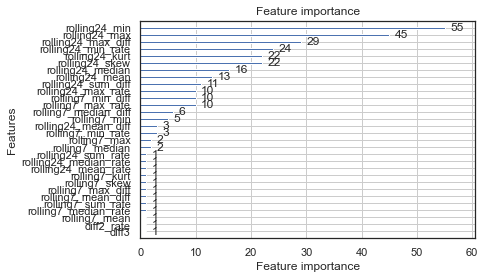

In [174]:
lgb.plot_importance(bst)

In [190]:
result = bst.predict(testt.drop(['timestamp', 'label'], axis=1), 
            num_iteration=bst.best_iteration)
result
metrics.precision_recall_curve(testt.label.tolist(), result, 0.6)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass pos_label=0.6 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


(array([0., 1.]), array([nan,  0.]), array([0.79657957]))

In [194]:
threshold = 0.5
for i in range(len(result)):
    if result[i] <= threshold:
        result[i] = 0
    else: 
        result[i] = 1
accuracy = metrics.accuracy_score(result,testt.label.tolist() )
metrics.f1_score(result,testt.label.tolist())
#sum([1 if result[i] == testt.label.tolist()[i] else 0 for i in range(len(result))])/len(result)

0.455981941309255

In [186]:
sum(result)

4417.0

In [187]:
sum(testt.label.tolist())

1785

In [188]:
metrics.precision_score(testt.label.tolist(), result)

0.3201267828843106

In [195]:
metrics.recall_score(testt.label.tolist(), result)

0.792156862745098

(array([17127.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4417.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

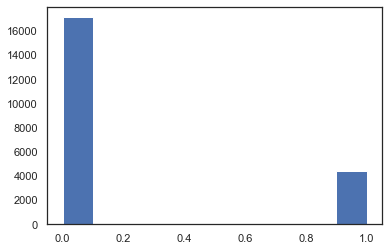

In [178]:
plt.hist(result)

(array([19759.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1785.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

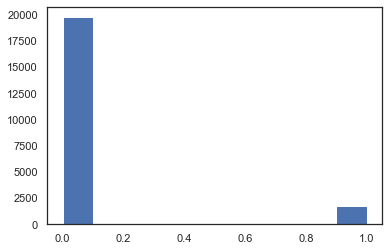

In [179]:
plt.hist(testt.label.tolist())

### Evaluate total 29

In [93]:
def evaluate(num, num_lag=7, inp_win_list=[7, 24], num_round=10):
    ## SELECT
    number = num
    KPI_name = unq[number]
    selected = data[data['KPI ID'] == KPI_name]
    anomaly  = selected.query('label == 1')
    print("Anomaly percentage for "+str(number+1)+"th", "is", round(100*anomaly.shape[0]/selected.shape[0], 4), "%")
    
    ## PLOT
    # time series with anomalies
    fig, ax = plt.subplots()
    ax.plot(selected.value, zorder=1)
    ax.scatter(anomaly.index, anomaly.value, color="r", s=5, zorder=2)
    plt.title("The " + str(number + 1) + " th KPI name")
    plt.show()
    # boxplot
    fig, axes = plt.subplots(1,2,figsize=(15, 5))
    fig.suptitle("Boxplots")
    sns.boxplot(ax=axes[0], x=selected.value).set_title("For all values")
    sns.boxplot(ax=axes[1], x=anomaly.value).set_title("Anomalies only")
    
    ## SPLIT -- train & evaluation set
    num_split = int(selected.shape[0]*0.7)
    train = selected[:num_split]
    evalt = selected[num_split:]
    # Visulization
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(train.value, lags=50)  ### tbc ? maybe has sth to do with num_lag?

    ## FEATURE
    # Lags
    #num_lag = 7
    lag(train, num_lag)
    lag(evalt, num_lag)
    # Diff
    diff(train)
    diff(evalt)
    # Rolling window
    #inp_win_list = [7, 24]
    rolling_window(train, inp_win_list)
    rolling_window(evalt,  inp_win_list)
    
    # TRAIN
    # LightGBN
    # Get data
    train_data = lgb.Dataset(data=train.drop(['timestamp', 'label', 'KPI ID'], axis=1),
                            label=train.label)
    valid_sets = lgb.Dataset(data=evalt.drop(['timestamp', 'label', 'KPI ID'], axis=1),
                            label=evalt.label)
    # Training
    #num_round = 10 # For now
    bst = lgb.train(param, train_data, num_round, valid_sets=valid_sets, early_stopping_rounds=5) # Early Stopping
    bst
    lgb.plot_importance(bst)

Anomaly percentage for 1th is 6.8355 %


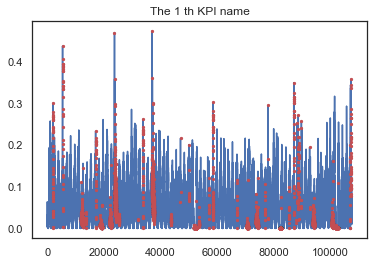

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 4956, number of negative: 70445
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 75401, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065729 -> initscore=-2.654233
[LightGBM] [Info] Start training from score -2.654233
[1]	valid_0's auc: 0.905001
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.908072
[3]	valid_0's auc: 0.922752
[4]	valid_0's auc: 0.920028
[5]	valid_0's auc: 0.924251
[6]	valid_0's auc: 0.934544
[7]	valid_0's auc: 0.933526
[8]	valid_0's auc: 0.93401
[9]	valid_0's auc: 0.936677
[10]	valid_0's auc: 0.938926
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.938926
Anomaly percentage for 2th is 1.0587 %


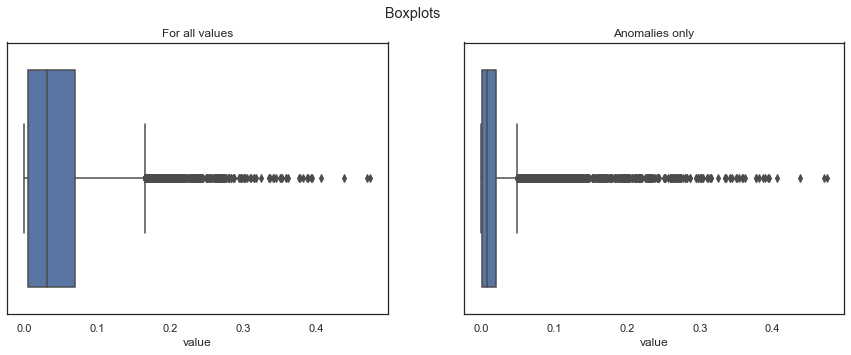

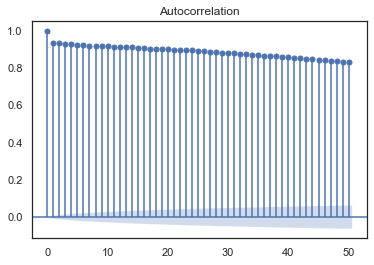

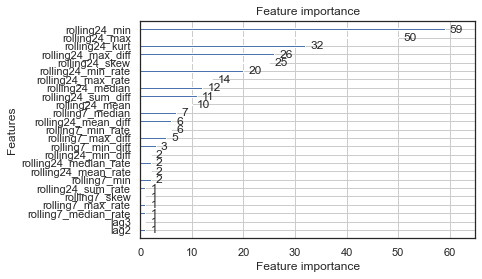

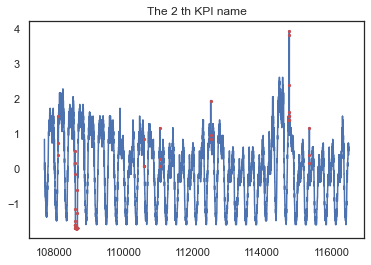

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 81, number of negative: 6067
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7503
[LightGBM] [Info] Number of data points in the train set: 6148, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013175 -> initscore=-4.316170
[LightGBM] [Info] Start training from score -4.316170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.950426
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.915825
[3]	valid_0's auc: 0.918842
[4]	valid_0's auc: 0.918763
[5]	valid_0's auc: 0.918556
[6]	valid_0's auc: 0.921494
Early stopping, best iteration is:
[1]	valid_0's auc: 0.950426
Anomaly percentage for 3th is 1.5981 %


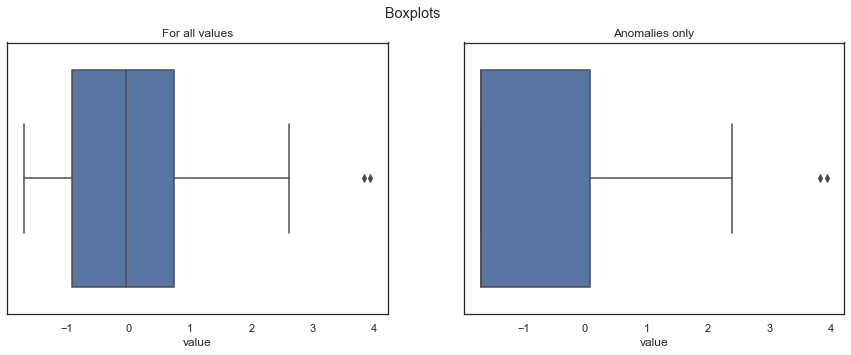

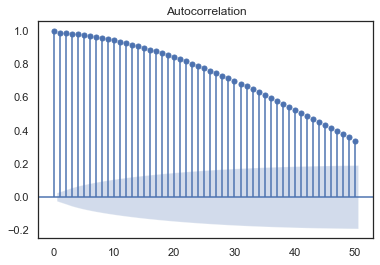

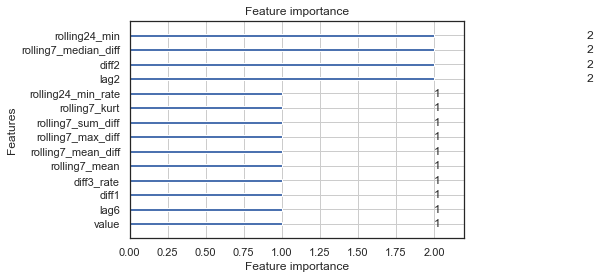

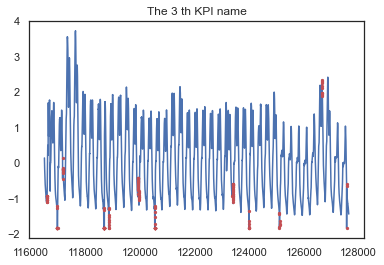

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 157, number of negative: 7639
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12238
[LightGBM] [Info] Number of data points in the train set: 7796, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020139 -> initscore=-3.884776
[LightGBM] [Info] Start training from score -3.884776
[1]	valid_0's auc: 0.695717
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.742562
[3]	valid_0's auc: 0.745236
[4]	valid_0's auc: 0.744139
[5]	valid_0's auc: 0.744641
[6]	valid_0's auc: 0.742404
[7]	valid_0's auc: 0.71349
[8]	valid_0's auc: 0.760005
[9]	valid_0's auc: 0.761037
[10]	valid_0's auc: 0.761697
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.761697
Anomaly percentage for 4th is 0.6993 %


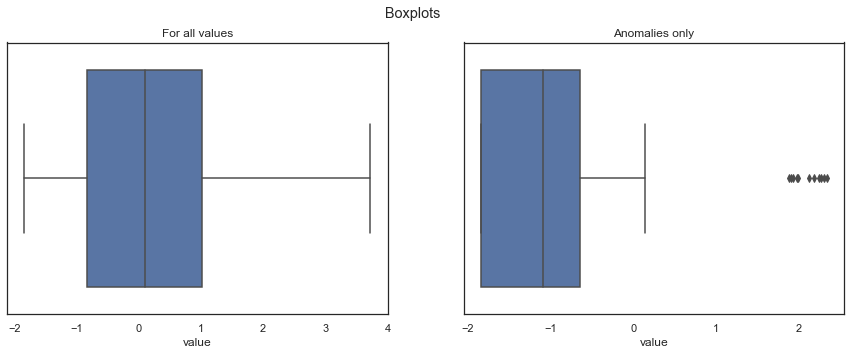

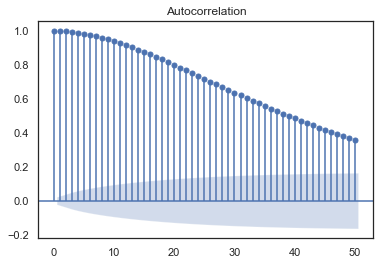

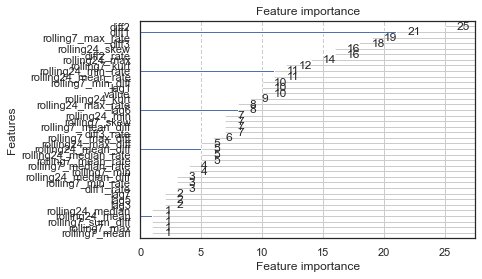

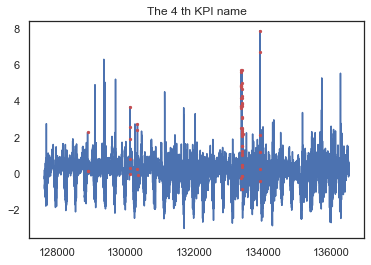

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 56, number of negative: 6150
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12214
[LightGBM] [Info] Number of data points in the train set: 6206, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009024 -> initscore=-4.698856
[LightGBM] [Info] Start training from score -4.698856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.907341
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.744474
[3]	valid_0's auc: 0.575923
[4]	valid_0's auc: 0.562045
[5]	valid_0's auc: 0.588985
[6]	valid_0's auc: 0.577838
Early stopping, best iteration is:
[1]	valid_0's auc: 0.907341
Anomaly percentage for 5th is 3.9377 %


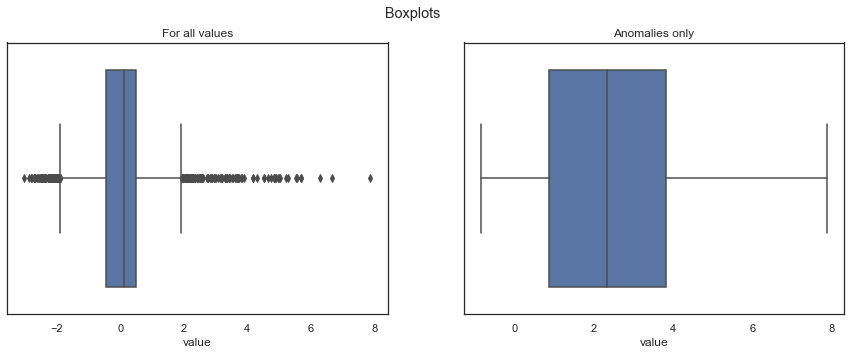

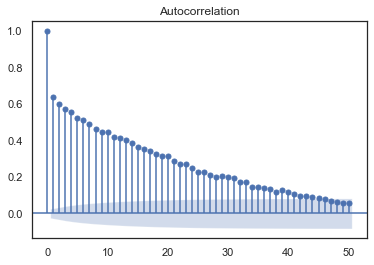

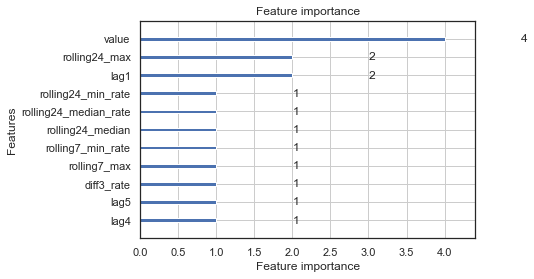

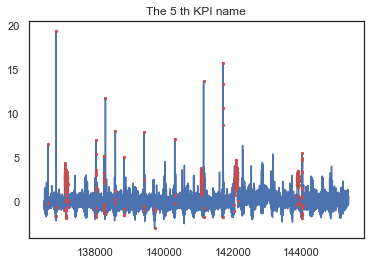

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 278, number of negative: 5926
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12209
[LightGBM] [Info] Number of data points in the train set: 6204, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044810 -> initscore=-3.059484
[LightGBM] [Info] Start training from score -3.059484
[1]	valid_0's auc: 0.949091
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.944457
[3]	valid_0's auc: 0.944323
[4]	valid_0's auc: 0.937012
[5]	valid_0's auc: 0.936203
[6]	valid_0's auc: 0.958753
[7]	valid_0's auc: 0.971404
[8]	valid_0's auc: 0.971197
[9]	valid_0's auc: 0.971412
[10]	valid_0's auc: 0.971311
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.971412


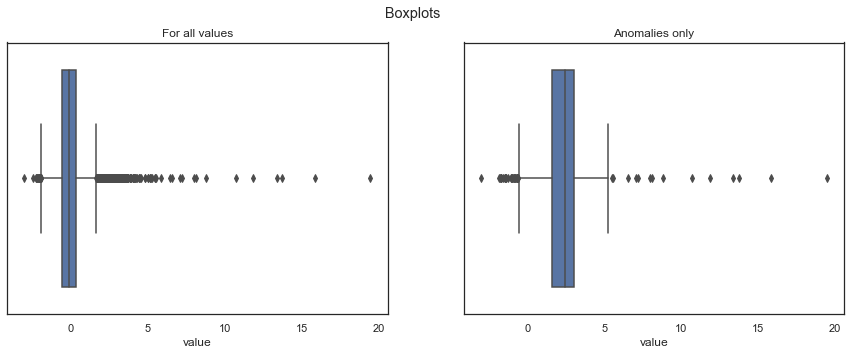

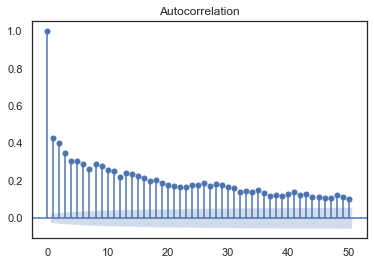

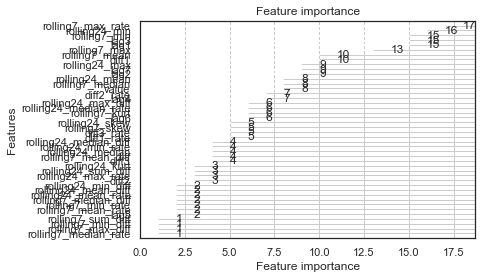

In [94]:
# for i in range(5):
#     evaluate(i)

Anomaly percentage for 7th is 0.0683 %


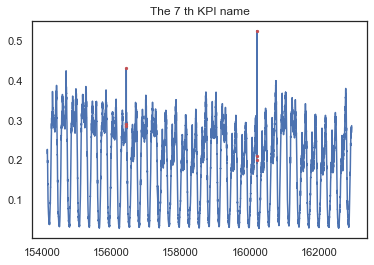

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 6, number of negative: 6142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12228
[LightGBM] [Info] Number of data points in the train set: 6148, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000976 -> initscore=-6.931146
[LightGBM] [Info] Start training from score -6.931146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 1
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's auc: 1
[5]	valid_0's auc: 1
[6]	valid_0's auc: 1
Early stopping, best i

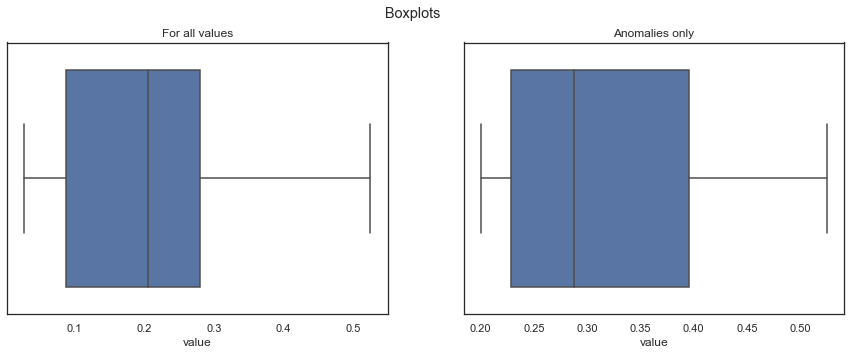

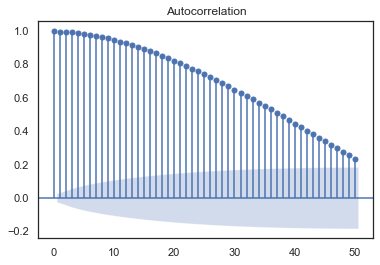

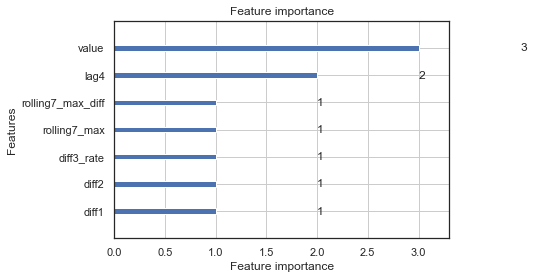

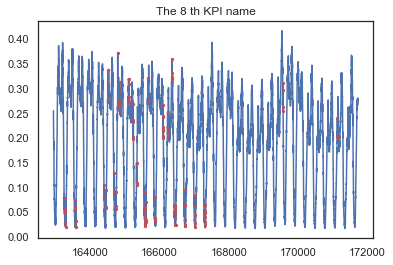

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 107, number of negative: 6041
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12229
[LightGBM] [Info] Number of data points in the train set: 6148, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017404 -> initscore=-4.033496
[LightGBM] [Info] Start training from score -4.033496
[1]	valid_0's auc: 0.831685
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.741971
[3]	valid_0's auc: 0.731158
[4]	valid_0's auc: 0.725778
[5]	valid_0's auc: 0.734473
[6]	valid_0's auc: 0.857333
[7]	valid_0's auc: 0.908683
[8]	valid_0's auc: 0.905342
[9]	valid_0's auc: 0.903902
[10]	valid_0's auc: 0.878172
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.908683
Anomaly percentage for 9th is 0.0853 %


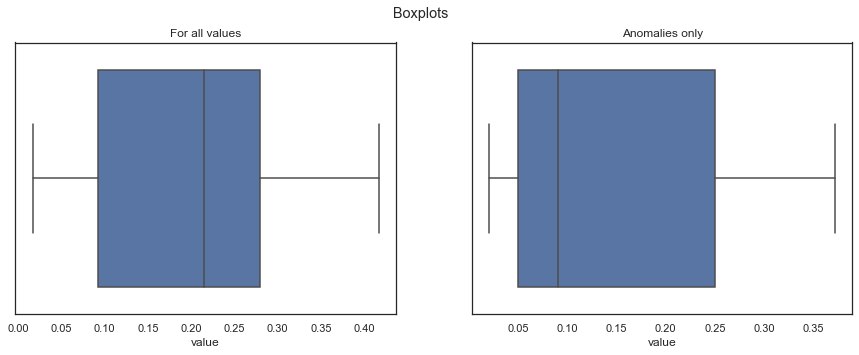

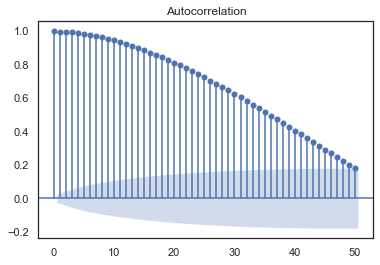

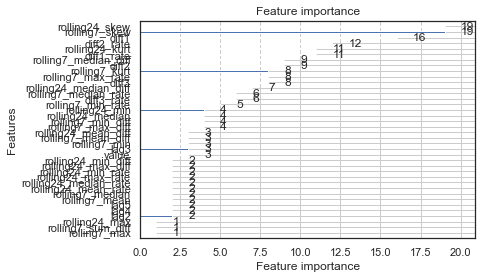

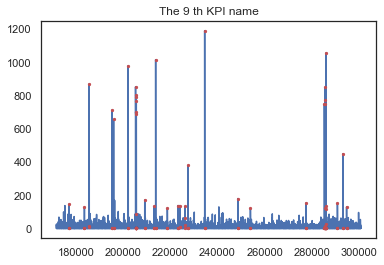

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 72, number of negative: 90222
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11353
[LightGBM] [Info] Number of data points in the train set: 90294, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000797 -> initscore=-7.133362
[LightGBM] [Info] Start training from score -7.133362
[1]	valid_0's auc: 0.801936
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.831222
[3]	valid_0's auc: 0.828228
[4]	valid_0's auc: 0.827747
[5]	valid_0's auc: 0.832014
[6]	valid_0's auc: 0.829585
[7]	valid_0's auc: 0.612853
[8]	valid_0's auc: 0.759629
[9]	valid_0's auc: 0.49624
[10]	valid_0's auc: 0.495701
Early stopping, best iteration is:
[5]	valid_0's auc: 0.832014
Anomaly percentage for 10th is 5.739 %

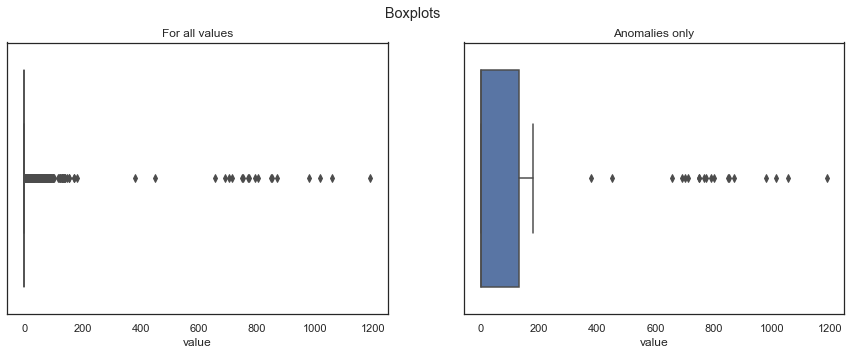

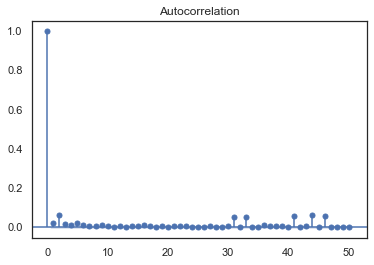

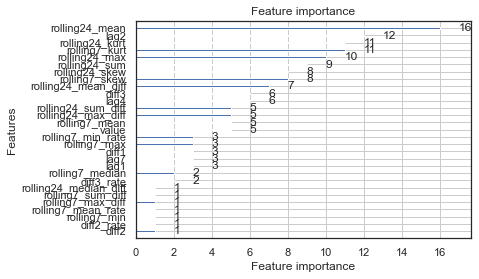

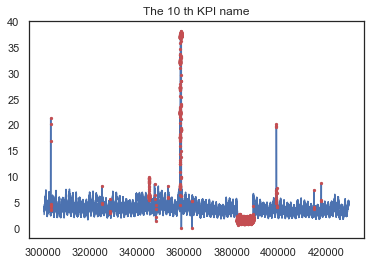

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 7370, number of negative: 82840
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11769
[LightGBM] [Info] Number of data points in the train set: 90210, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081698 -> initscore=-2.419493
[LightGBM] [Info] Start training from score -2.419493
[1]	valid_0's auc: 0.938247
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.937859
[3]	valid_0's auc: 0.937066
[4]	valid_0's auc: 0.937072
[5]	valid_0's auc: 0.937195
[6]	valid_0's auc: 0.937257
Early stopping, best iteration is:
[1]	valid_0's auc: 0.938247


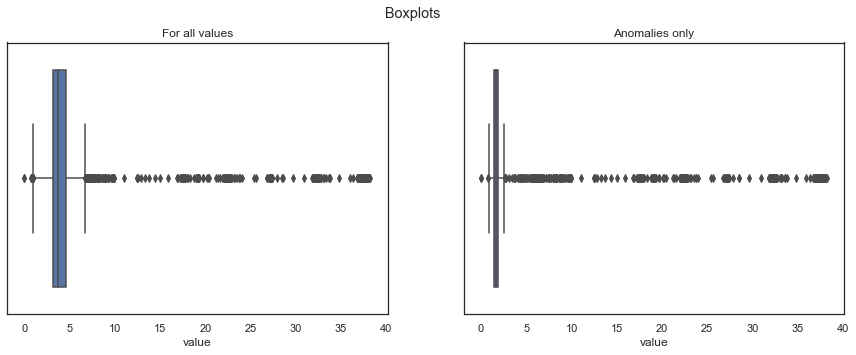

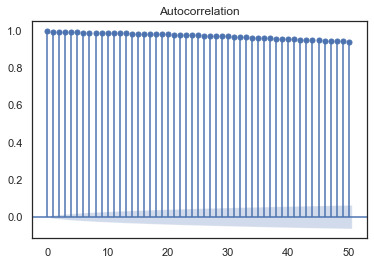

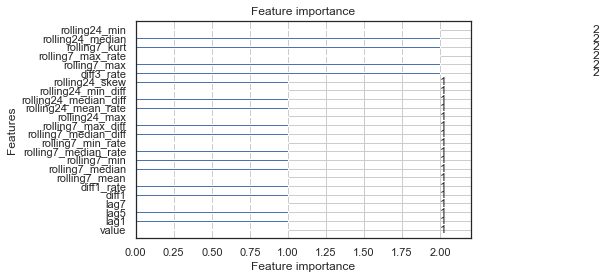

In [95]:
# for i in range(6,10):
#     evaluate(i)

Anomaly percentage for 11th is 5.312 %


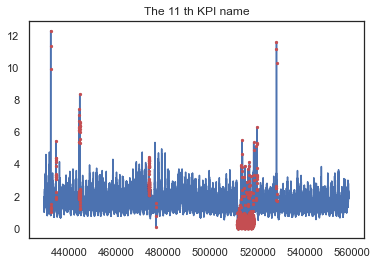

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 6844, number of negative: 83463
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11009
[LightGBM] [Info] Number of data points in the train set: 90307, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075786 -> initscore=-2.501031
[LightGBM] [Info] Start training from score -2.501031
[1]	valid_0's auc: 0.721757
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.942986
[3]	valid_0's auc: 0.942963
[4]	valid_0's auc: 0.94326
[5]	valid_0's auc: 0.943172
[6]	valid_0's auc: 0.943172
[7]	valid_0's auc: 0.943159
[8]	valid_0's auc: 0.943208
[9]	valid_0's auc: 0.943214
Early stopping, best iteration is:
[4]	valid_0's auc: 0.94326
Anomaly percentage for 12th is 5.2972 %


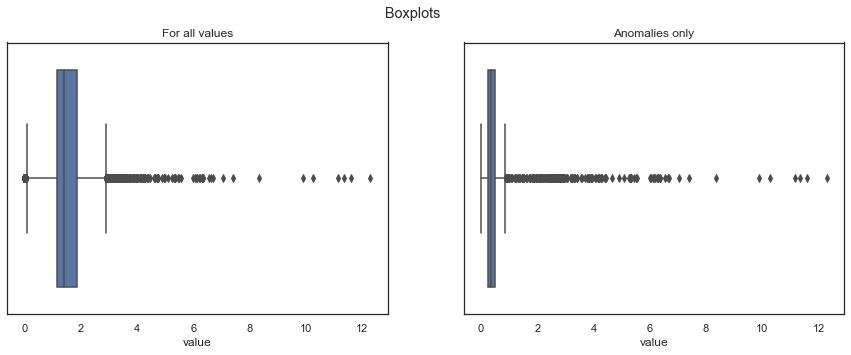

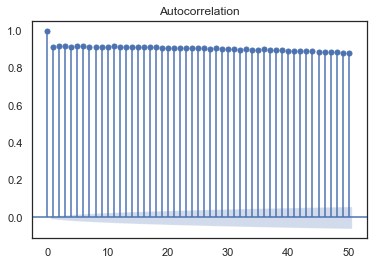

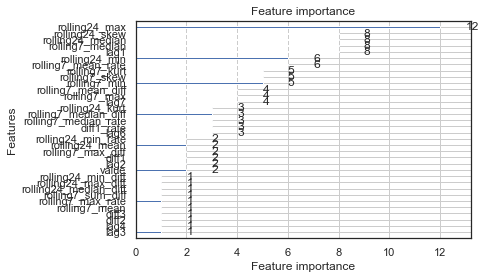

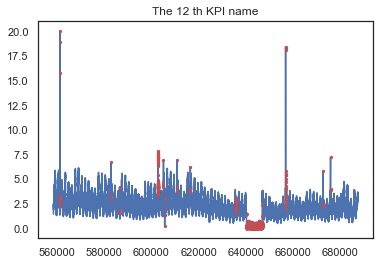

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 6793, number of negative: 83355
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11360
[LightGBM] [Info] Number of data points in the train set: 90148, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075354 -> initscore=-2.507216
[LightGBM] [Info] Start training from score -2.507216
[1]	valid_0's auc: 0.884653
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.878586
[3]	valid_0's auc: 0.878842
[4]	valid_0's auc: 0.878703
[5]	valid_0's auc: 0.878265
[6]	valid_0's auc: 0.912524
[7]	valid_0's auc: 0.945557
[8]	valid_0's auc: 0.94547
[9]	valid_0's auc: 0.94581
[10]	valid_0's auc: 0.94581
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.94581
Anomaly percentage for 13th is 0.0815 %


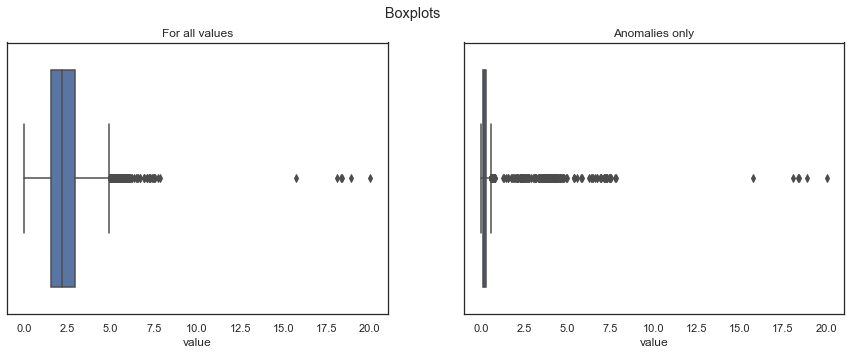

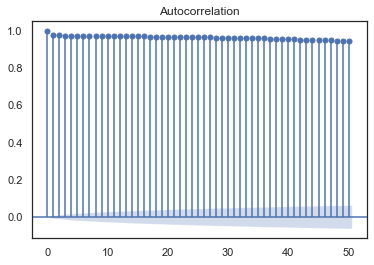

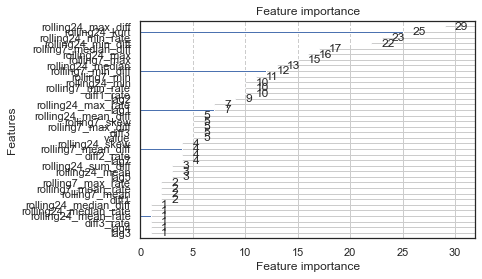

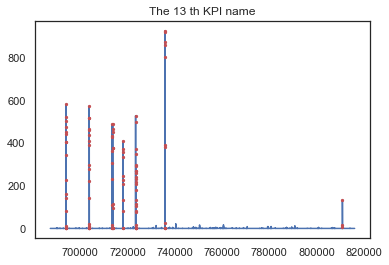

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 102, number of negative: 90048
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7644
[LightGBM] [Info] Number of data points in the train set: 90150, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001131 -> initscore=-6.783125
[LightGBM] [Info] Start training from score -6.783125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's auc: 0.469379
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's auc: 0.469246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's auc: 0.469401
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

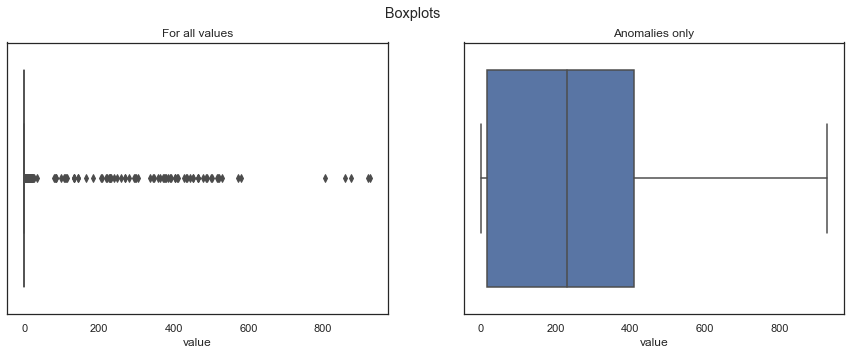

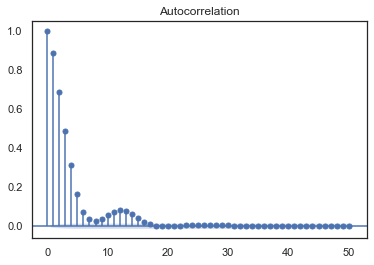

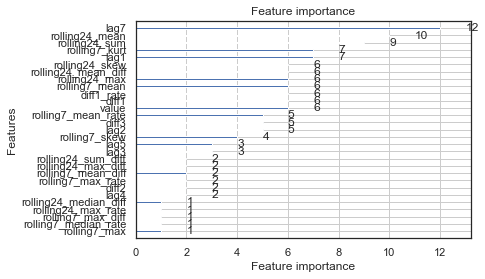

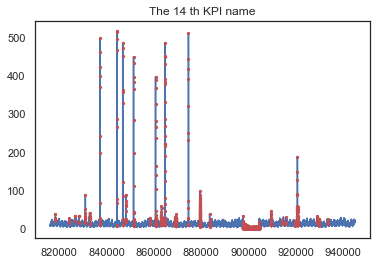

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 7090, number of negative: 83062
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12231
[LightGBM] [Info] Number of data points in the train set: 90152, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078645 -> initscore=-2.460902
[LightGBM] [Info] Start training from score -2.460902
[1]	valid_0's auc: 0.939599
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.943025
[3]	valid_0's auc: 0.958037
[4]	valid_0's auc: 0.957838
[5]	valid_0's auc: 0.963998
[6]	valid_0's auc: 0.964848
[7]	valid_0's auc: 0.964613
[8]	valid_0's auc: 0.964464
[9]	valid_0's auc: 0.963856
[10]	valid_0's auc: 0.963875
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.964848
Anomaly percentage for 15th is 6.3714 %


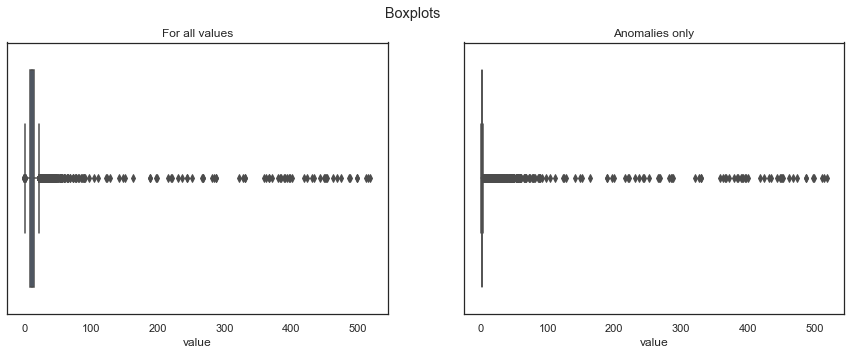

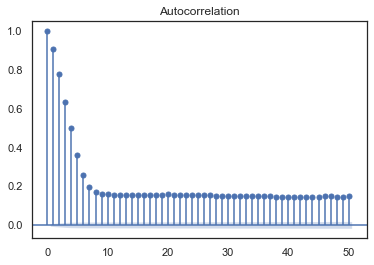

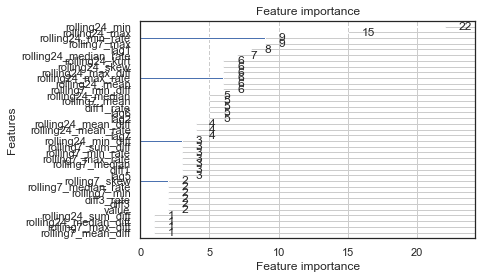

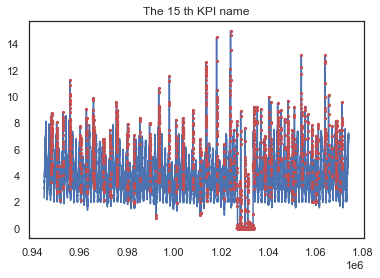

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 7731, number of negative: 82601
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11894
[LightGBM] [Info] Number of data points in the train set: 90332, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085584 -> initscore=-2.368784
[LightGBM] [Info] Start training from score -2.368784
[1]	valid_0's auc: 0.963892
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.982075
[3]	valid_0's auc: 0.982042
[4]	valid_0's auc: 0.987533
[5]	valid_0's auc: 0.987518
[6]	valid_0's auc: 0.987515
[7]	valid_0's auc: 0.989503
[8]	valid_0's auc: 0.98948
[9]	valid_0's auc: 0.989482
[10]	valid_0's auc: 0.989444
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.989503
Anomaly percentage for 16th is 0.7275 %


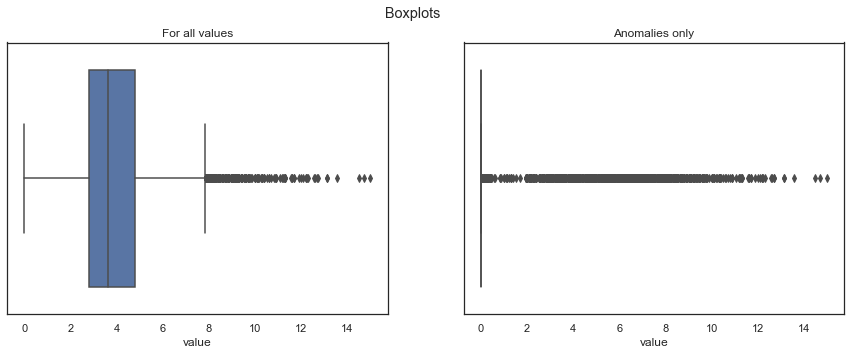

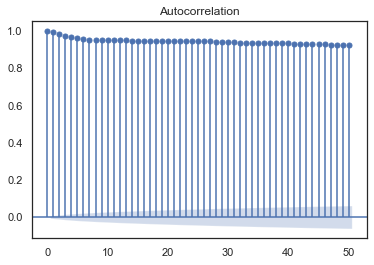

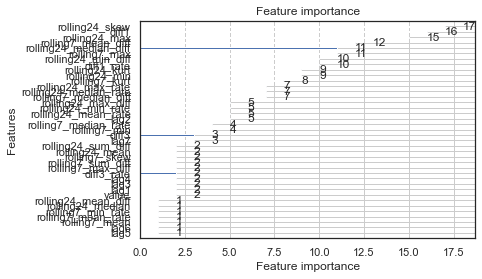

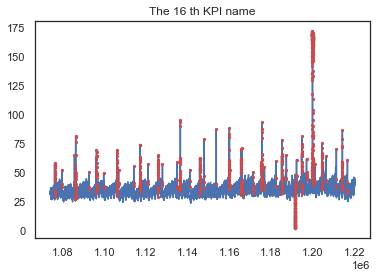

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 514, number of negative: 101863
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 102377, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005021 -> initscore=-5.289161
[LightGBM] [Info] Start training from score -5.289161
[1]	valid_0's auc: 0.50632
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.606585
[3]	valid_0's auc: 0.609213
[4]	valid_0's auc: 0.564254
[5]	valid_0's auc: 0.560671
[6]	valid_0's auc: 0.552495
[7]	valid_0's auc: 0.551521
[8]	valid_0's auc: 0.556246
Early stopping, best iteration is:
[3]	valid_0's auc: 0.609213
Anomaly percentage for 17th is 0.6003 %


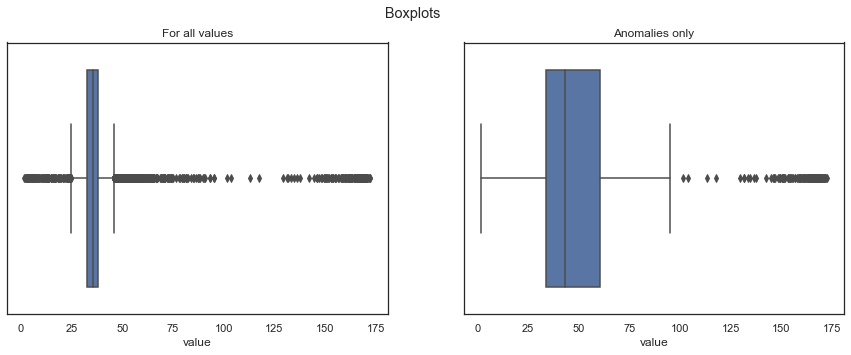

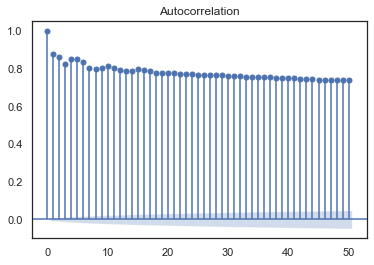

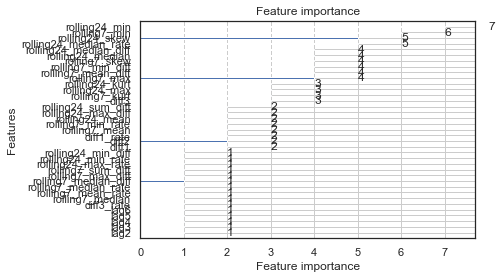

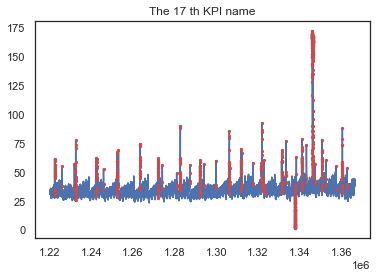

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 374, number of negative: 102004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 102378, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003653 -> initscore=-5.608512
[LightGBM] [Info] Start training from score -5.608512
[1]	valid_0's auc: 0.576304
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.507924
[3]	valid_0's auc: 0.571564
[4]	valid_0's auc: 0.566182
[5]	valid_0's auc: 0.584674
[6]	valid_0's auc: 0.596423
[7]	valid_0's auc: 0.58964
[8]	valid_0's auc: 0.615383
[9]	valid_0's auc: 0.626812
[10]	valid_0's auc: 0.625348
Did not meet early stopping. Best iteration is:
[9]	valid_0's auc: 0.626812
Anomaly percentage for 18th is 0.8786 %


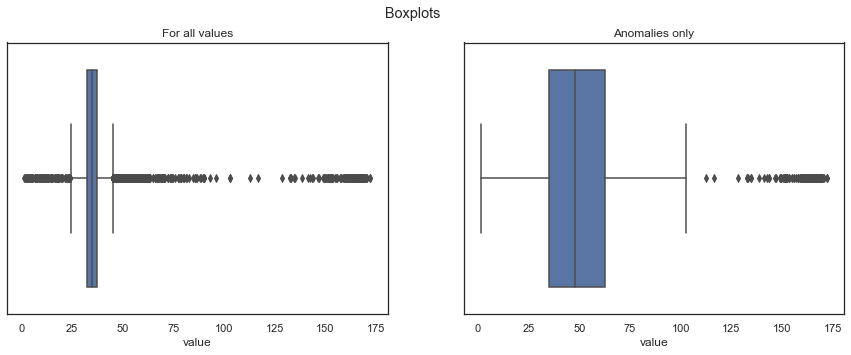

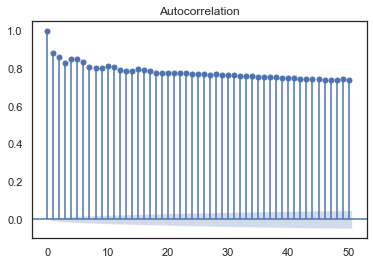

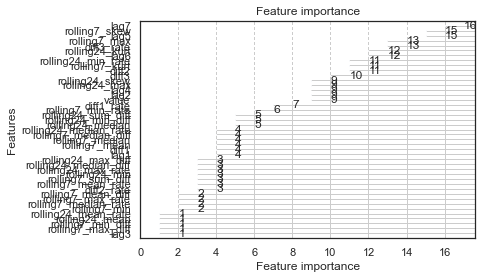

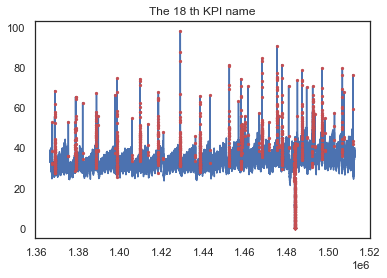

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 699, number of negative: 101679
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 102378, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006828 -> initscore=-4.979925
[LightGBM] [Info] Start training from score -4.979925
[1]	valid_0's auc: 0.611883
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.912228
[3]	valid_0's auc: 0.895986
[4]	valid_0's auc: 0.900308
[5]	valid_0's auc: 0.899611
[6]	valid_0's auc: 0.883481
[7]	valid_0's auc: 0.886475
Early stopping, best iteration is:
[2]	valid_0's auc: 0.912228
Anomaly percentage for 19th is 0.7666 %


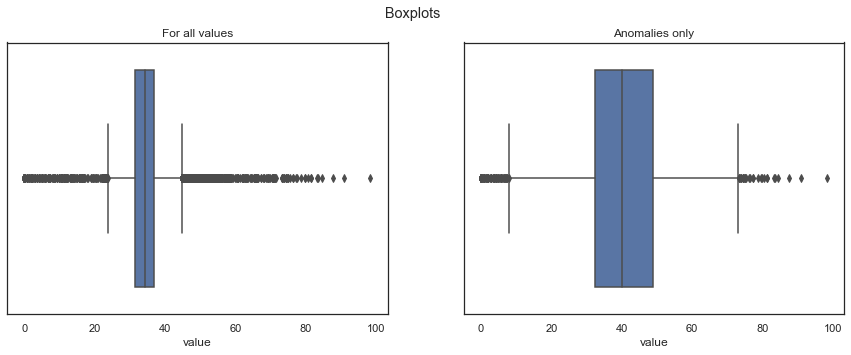

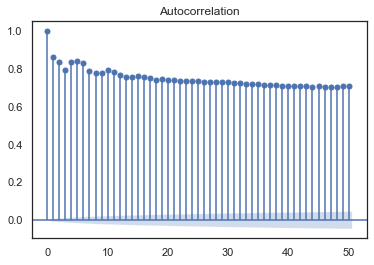

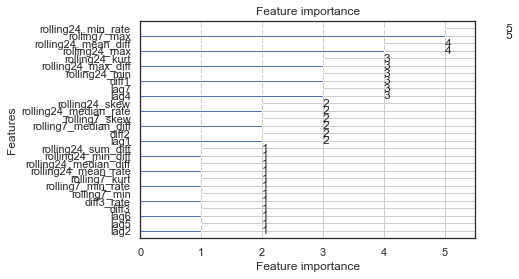

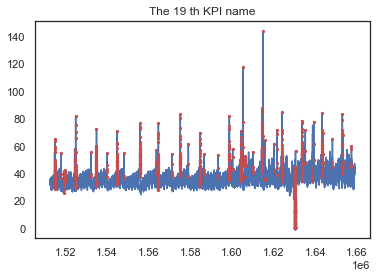

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 702, number of negative: 101657
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12239
[LightGBM] [Info] Number of data points in the train set: 102359, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006858 -> initscore=-4.975426
[LightGBM] [Info] Start training from score -4.975426
[1]	valid_0's auc: 0.931779
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.910185
[3]	valid_0's auc: 0.902086
[4]	valid_0's auc: 0.884546
[5]	valid_0's auc: 0.871865
[6]	valid_0's auc: 0.868659
Early stopping, best iteration is:
[1]	valid_0's auc: 0.931779
Anomaly percentage for 20th is 1.9065 %


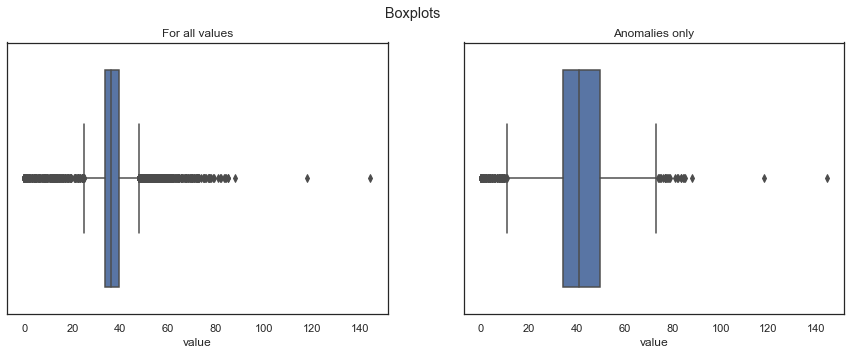

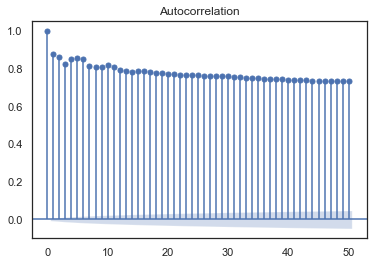

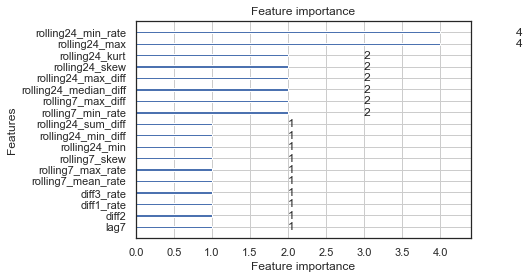

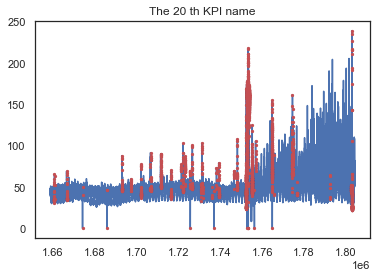

<ipython-input-84-09c0b7846668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag{}'.format(i)] = df.value.shift(i)
<ipython-input-85-c1dae0ba022a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff1'] = df['value'].diff()
<ipython-input-85-c1dae0ba022a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

[LightGBM] [Info] Number of positive: 2275, number of negative: 99319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 101594, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022393 -> initscore=-3.776357
[LightGBM] [Info] Start training from score -3.776357
[1]	valid_0's auc: 0.817587
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.81969
[3]	valid_0's auc: 0.826703
[4]	valid_0's auc: 0.827601
[5]	valid_0's auc: 0.82742
[6]	valid_0's auc: 0.827592
[7]	valid_0's auc: 0.828727
[8]	valid_0's auc: 0.831306
[9]	valid_0's auc: 0.83307
[10]	valid_0's auc: 0.836699
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.836699


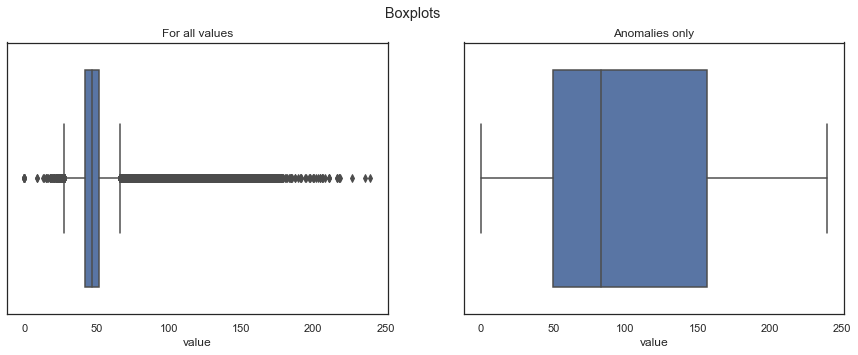

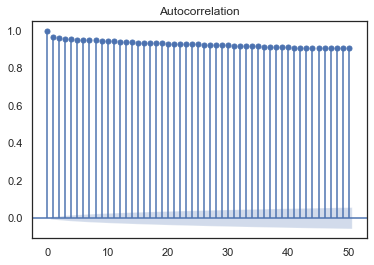

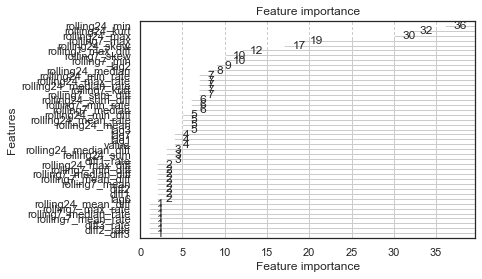

In [97]:
# for i in range(10, 20):
#     evaluate(i)

In [ ]:
# 特征筛选
# 模型融合 e.g. xgboost 和 lbg bagging，
# https://zhuanlan.zhihu.com/p/131272835 （above)

### References

https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/